In [1]:
# ignore warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:

#imports
from pathlib import Path
import datetime as dt
import hvplot.pandas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geoviews as gv
import geoviews.feature as gf
from geoviews import dim, opts
import altair as alt
from vega_datasets import data
import scipy
from scipy import stats

# Data Cleaning

### Lat/Lon CSV Cleaning

In [3]:
# name csv path
world_geo_path = Path("world_geo_data.csv")

# create dataframe from csv
world_geo_df =pd.read_csv(world_geo_path)

world_geo_df.head()

,country_code,latitude,longitude,country,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state
0,AD,42.546245,1.601554,Andorra,AK,63.588753,-154.493062,Alaska
1,AE,23.424076,53.847818,United Arab Emirates,AL,32.318231,-86.902298,Alabama
2,AF,33.939110,67.709953,Afghanistan,AR,35.201050,-91.831833,Arkansas
3,AG,17.060816,-61.796428,Antigua and Barbuda,AZ,34.048928,-111.093731,Arizona
4,AI,18.220554,-63.068615,Anguilla,CA,36.778261,-119.417932,California


In [4]:
# rename columns for clarity and consistency
world_geo_df.rename(columns={"country_code": "alpha-2"}, inplace=True)

# drop unnecessary columns
world_geo_df.drop(labels=["usa_state_code",
    "usa_state_latitude",
    "usa_state_longitude",
    "usa_state"
    ], axis=1, inplace=True)

world_geo_df.head()


,alpha-2,latitude,longitude,country
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [5]:
# check for nulls
nulls = world_geo_df.isnull().any(axis=1)
null_rows = world_geo_df[nulls]
display(null_rows)

,alpha-2,latitude,longitude,country
156,NaN,-22.95764,18.49041,Namibia
226,UM,NaN,NaN,U.S. Minor Outlying Islands


In [6]:
# fix alpha-2 for Namibia
world_geo_df.at[156, "alpha-2"] = "NA"

# check
print(world_geo_df.at[156, "alpha-2"])

# delete row for US Minor Outlying Islands because their geography is not bound by lon/lat
world_geo_df.drop(226, inplace=True)

# check
nulls = world_geo_df.isnull().any(axis=1)
null_rows = world_geo_df[nulls]
display(null_rows)


NA


,alpha-2,latitude,longitude,country


In [7]:
# check data types
world_geo_df.dtypes

alpha-2       object
latitude     float64
longitude    float64
country       object
dtype: object

### World Inflation CSV Cleaning

In [8]:
# name csv path
world_inflation_path = Path("world_inflation_data.csv")

# create dataframe from csv, skipping blank rows and naming the header
world_inflation_df =pd.read_csv(world_inflation_path, header=2, skiprows=[0, 1])

world_inflation_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.773751
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.439201,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8.777814,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN


In [9]:
# drop unnecessary columns
world_inflation_df.drop(columns=["Indicator Name", "Indicator Code"], inplace=True)

# rename country_code column for clarity and consistency
world_inflation_df.rename(columns={"Country Code": "alpha-3", "Country Name":"country"}, inplace=True)

world_inflation_df.head()

,country,alpha-3,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.773751
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.439201,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.777814,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN


In [10]:
# check data types
world_inflation_df.dtypes

country     object
alpha-3     object
1960       float64
1961       float64
1962       float64
            ...   
2018       float64
2019       float64
2020       float64
2021       float64
2022       float64
Length: 65, dtype: object

### ISO2/ISO3 CSV Cleaning

In [11]:
# path
country_info_path = Path("country_info.csv")

# create dataframe from csv
country_info_df = pd.read_csv(country_info_path)

country_info_df.head()


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [12]:
# keep necessary columns
country_info_df = country_info_df[["name", "alpha-2", "alpha-3"]]

# change column names for consistency and clarity
country_info_df.rename(columns={"name":"country"}, inplace=True)

country_info_df.head()

,country,alpha-2,alpha-3
0,Afghanistan,AF,AFG
1,Åland Islands,AX,ALA
2,Albania,AL,ALB
3,Algeria,DZ,DZA
4,American Samoa,AS,ASM


In [13]:
# check for nulls
nulls = country_info_df.isnull().any(axis=1)
null_rows = country_info_df[nulls]
display(null_rows)

,country,alpha-2,alpha-3
153,Namibia,NaN,NAM


In [14]:
# fix issue with Namibia alpha-2 (NaN)
country_info_df.at[153, "alpha-2"] = "NA"
# check
print(country_info_df.at[153, "alpha-2"])

NA


In [15]:
# check datatypes
country_info_df.dtypes

country    object
alpha-2    object
alpha-3    object
dtype: object

# Combining 3 Dataframes

In [16]:
# view dataframes together
display(country_info_df.head())
display(world_inflation_df.head())
display(world_geo_df.head())

,country,alpha-2,alpha-3
0,Afghanistan,AF,AFG
1,Åland Islands,AX,ALA
2,Albania,AL,ALB
3,Algeria,DZ,DZA
4,American Samoa,AS,ASM


,country,alpha-3,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.773751
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.439201,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.777814,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN


,alpha-2,latitude,longitude,country
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [17]:
# merge dataframes (merge instead of join because of dissimilar indexes)
combined_df = country_info_df.merge(world_geo_df, how="inner", on="alpha-2")
combined_df = combined_df.merge(world_inflation_df, how="inner", on="alpha-3")
combined_df

,country_x,alpha-2,alpha-3,latitude,longitude,country_y,country,1960,1961,1962,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AF,AFG,33.939110,67.709953,Afghanistan,Afghanistan,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
1,Albania,AL,ALB,41.153332,20.168331,Albania,Albania,NaN,NaN,NaN,...,1.937621,1.625865,1.896174,1.275432,1.986661,2.028060,1.411091,1.620887,2.041472,6.725203
2,Algeria,DZ,DZA,28.033886,1.659626,Algeria,Algeria,NaN,NaN,NaN,...,3.254239,2.916927,4.784447,6.397695,5.591116,4.269990,1.951768,2.415131,7.226063,9.265516
3,American Samoa,AS,ASM,-14.270972,-170.132217,American Samoa,American Samoa,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AD,AND,42.546245,1.601554,Andorra,Andorra,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Virgin Islands (British),VG,VGB,18.420695,-64.639968,British Virgin Islands,British Virgin Islands,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,Virgin Islands (U.S.),VI,VIR,18.335765,-64.896335,U.S. Virgin Islands,Virgin Islands (U.S.),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,Yemen,YE,YEM,15.552727,48.516388,Yemen,"Yemen, Rep.",NaN,NaN,NaN,...,10.968442,8.104726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,Zambia,ZM,ZMB,-13.133897,27.849332,Zambia,Zambia,NaN,NaN,NaN,...,6.977676,7.806876,10.110593,17.869730,6.577312,7.494572,9.150316,15.733060,22.020768,10.993204


In [18]:
# drop duplicate columns
combined_df.drop(columns= ["country_y", "country", "alpha-2", "alpha-3"], inplace=True)

# rename country_x
combined_df.rename(columns={"country_x":"country"}, inplace=True)

# assign index
combined_df.set_index("country", inplace=True)

# sort by index
combined_df.sort_index(inplace=True)

# check
combined_df


,latitude,longitude,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.939110,67.709953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
Albania,41.153332,20.168331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.937621,1.625865,1.896174,1.275432,1.986661,2.028060,1.411091,1.620887,2.041472,6.725203
Algeria,28.033886,1.659626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.254239,2.916927,4.784447,6.397695,5.591116,4.269990,1.951768,2.415131,7.226063,9.265516
American Samoa,-14.270972,-170.132217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,42.546245,1.601554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (British),18.420695,-64.639968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Virgin Islands (U.S.),18.335765,-64.896335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,15.552727,48.516388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.968442,8.104726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
combined_df.dtypes

latitude     float64
longitude    float64
1960         float64
1961         float64
1962         float64
              ...   
2018         float64
2019         float64
2020         float64
2021         float64
2022         float64
Length: 65, dtype: object

# Data Visualizations

### Dot Map

calculations

In [20]:
# isolate 2022 in new df
inflation_target_year_df = combined_df[["latitude", "longitude", "2022"]]
# rename column for map
inflation_target_year_df.rename(columns={"2022":"Inflation Rate (2022)"}, inplace=True)
# drop nulls
inflation_target_year_df.dropna(inplace=True)

# calculate mean inflation overall during a specified time period
mean_world_inflation =  combined_df.iloc[:,-10:]

# find zscores to eliminate outliers that are skewing mean data (by country)
# for ease of masking, make absolute value
# attributed resouce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
mean_world_inflation_zscores = abs(scipy.stats.zscore(mean_world_inflation, axis=1, nan_policy='omit'))

# mask dataframe based on zscore
# attributed resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
mean_world_inflation.mask(mean_world_inflation_zscores > 3, None, inplace=True)

# calculate mean
mean_world_inflation = mean_world_inflation.mean(axis=1, skipna=True)

# add to df
inflation_target_year_df["Mean Inflation"] = mean_world_inflation

# 2022 inflation as percentage of mean
inflation_target_year_df["2022 Inflation Rate Relative to 10-Year Mean Inflation"] = inflation_target_year_df["Inflation Rate (2022)"] / inflation_target_year_df["Mean Inflation"] * 100

display(inflation_target_year_df.head())

,latitude,longitude,Inflation Rate (2022),Mean Inflation,2022 Inflation Rate Relative to 10-Year Mean Inflation
country,,,,,
Albania,41.153332,20.168331,6.725203,2.254846,298.255466
Algeria,28.033886,1.659626,9.265516,4.807289,192.738884
Antigua and Barbuda,17.060816,-61.796428,7.531078,1.791956,420.271357
Armenia,40.069099,45.038189,8.640911,3.306948,261.295668
Australia,-25.274398,133.775136,6.594097,2.349890,280.613020


In [21]:
# describe last 20 years of inflation data
stats_df = inflation_target_year_df.iloc[:,-1]
summary_stats = stats_df.describe(include="all")
print(summary_stats)

# fine outliers visually
inflation_target_year_df["2022 Inflation Rate Relative to 10-Year Mean Inflation"].hvplot.box(ylim=(0,1000))

count     163.000000
mean      356.631191
std       548.986807
min        38.215381
25%       174.164405
50%       268.409884
75%       432.936831
max      6839.405508
Name: 2022 Inflation Rate Relative to 10-Year Mean Inflation, dtype: float64


:BoxWhisker   (2022 Inflation Rate Relative to 10-Year Mean Inflation)

data visualization

In [22]:

map = inflation_target_year_df.hvplot.points(
    "longitude",
    "latitude",
    geo=True,
    tiles="CartoLight",
    xlabel="longitude",
    ylabel="latitude",
    color="2022 Inflation Rate Relative to 10-Year Mean Inflation",
    clim=(0,800),
    frame_width=800,
    frame_height=400,
    cmap=["#b3f0ff", "#ffffff", "#ffd6cc", "#ff9980", "#ff3300", "#cc2900", "#801a00", "#330a00"],
    line_color="black",
    title="2022 Inflation Rate, Expressed as Percentage of 10-Year Mean",
    hover_cols=["country", "Inflation Rate (2022)"]
)

hvplot.save(map, "high_inflation_world_map.html")

map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (2022 Inflation Rate Relative to 10-Year Mean Inflation,country,Inflation Rate (2022))

### Heatmap for World Inflation (Percent Change) 1960-2022

calculations

In [23]:
# preview dataframe
display(combined_df.head())

# this automatically changes the df from wide to long
pct_change_world_inflation_df = combined_df

# drop lat/lon
pct_change_world_inflation_df.drop(columns=["latitude", "longitude"], inplace=True)

# limit to ten years
pct_change_world_inflation_df = pct_change_world_inflation_df.iloc[:, -10:]

# find zscores to eliminate outliers that are skewing mean data (by year)
# for ease of masking, make absolute value
# attributed resouce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
pct_change_world_inflation_df_zscores = abs(scipy.stats.zscore(pct_change_world_inflation_df, axis=0, nan_policy='omit'))

# mask dataframe based on zscore
# attributed resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
pct_change_world_inflation_df.mask(pct_change_world_inflation_df_zscores > 3, None, inplace=True)

# calculate mean by year
pct_change_world_inflation_df = pct_change_world_inflation_df.mean()

# change array to df
pct_change_world_inflation_df = pd.DataFrame(pct_change_world_inflation_df)

# name columns
pct_change_world_inflation_df.columns = ["percent change in inflation rate"]

# rename index
pct_change_world_inflation_df.rename_axis("year", inplace=True)

# reset index
pct_change_world_inflation_df.reset_index(inplace=True)

# preview df
display(pct_change_world_inflation_df.head())

,latitude,longitude,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.939110,67.709953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
Albania,41.153332,20.168331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.937621,1.625865,1.896174,1.275432,1.986661,2.028060,1.411091,1.620887,2.041472,6.725203
Algeria,28.033886,1.659626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.254239,2.916927,4.784447,6.397695,5.591116,4.269990,1.951768,2.415131,7.226063,9.265516
American Samoa,-14.270972,-170.132217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,42.546245,1.601554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,year,percent change in inflation rate
0,2013,3.596331
1,2014,3.262359
2,2015,2.819723
3,2016,3.616944
4,2017,3.489505


,percent change in inflation rate
count,10.000000
mean,4.327162
std,2.215846
min,2.819723
25%,3.392630
50%,3.554264
75%,3.708786
max,10.285945


<Axes: >

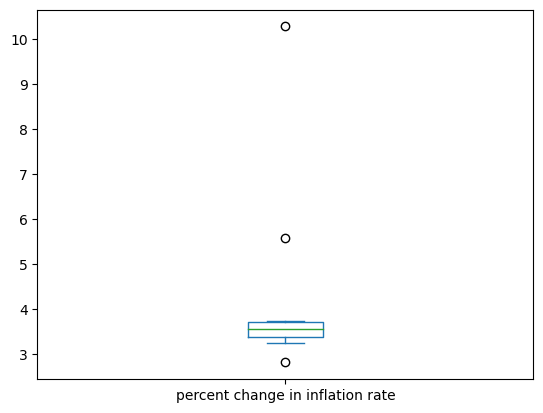

In [24]:
display(pct_change_world_inflation_df.describe())
pct_change_world_inflation_df.plot.box()

heatmap

In [31]:
# attributed resource: https://altair-viz.github.io/gallery/simple_heatmap.html

# create df with necessary data
heatmap_df = pct_change_world_inflation_df

# preview df
display(heatmap_df.head())

# advice from VS error on large datasets 
alt.data_transformers.enable("vegafusion")

# Configure heatmap
base = alt.Chart(heatmap_df, title="Aggregate Inflation Rate Worldwide 2013-2022").encode(
    x="year",
    y="percent change in inflation rate",
)

heatmap = base.mark_rect().encode(
    alt.Color("percent change in inflation rate", title=None)
    # scheme must be vega: https://vega.github.io/vega/docs/schemes/
        .scale(domain=[0, 15],scheme="yelloworangered")
)

# Configure text
text = base.mark_text(baseline="middle").encode(
    alt.Text("percent change in inflation rate", format=".2f"),
    color=alt.condition(
        alt.datum["percent change in inflation rate"],
        alt.value('black'),
        alt.value('black')
    )
)


# Draw the chart
heatmap + text.properties(
    width=800,
    height=400)


,year,percent change in inflation rate
0,2013,3.596331
1,2014,3.262359
2,2015,2.819723
3,2016,3.616944
4,2017,3.489505


alt.LayerChart(...)